In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import sys
import pandas as pd
import pickle
import pdb
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
from sklearn.model_selection import KFold

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append('/home/akumar/nse/neural_control')

In [4]:
from loaders import load_sabes, load_peanut
from utils import apply_df_filters

In [3]:
# Tasks:

# (1) Assess scores attained by FCCA across initializations
# (2) Assess subspace angles across initializations
# (3) Assess decoding performance across initializations

### Scores

In [5]:
with open('/mnt/Secondary/data/postprocessed/sabes_decoding_initvar_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)
sabes_df = pd.DataFrame(sabes_df)

In [10]:
sabes_df.iloc[0]['dimreduc_args']

{'T': 3, 'loss_type': 'trace', 'n_init': 1, 'rng_or_seed': 2}

In [6]:
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)
seeds = np.arange(20)
fcca_scores = np.zeros((dimvals.size, data_files.size, seeds.size, 5))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    for j, d in tqdm(enumerate(dimvals)):
        for s in seeds:
            train_test_idxs = list(KFold(n_splits=5).split(X))
            for f in range(5):
                train_idxs = test_test_idxs[f][0]
                df = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                    dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s}, fold_idx=f)
                assert(df.shape[0] == 1)
                lqgmodel = LQGCA(T=3)
                lqgscore = lqgmodel.score(X=X[train_idxs], coef=df.iloc[0]['coef'])
                fcca_scores[j, i, s, f] = lqgscore                    

15it [02:47, 11.18s/it]
15it [01:52,  7.47s/it]
15it [02:00,  8.04s/it]
15it [02:07,  8.50s/it]
15it [02:18,  9.23s/it]
15it [01:58,  7.88s/it]
15it [01:56,  7.74s/it]
15it [01:50,  7.35s/it]
15it [02:27,  9.85s/it]
15it [03:31, 14.09s/it]
15it [18:10, 72.72s/it]
15it [08:28, 33.87s/it]
15it [06:40, 26.68s/it]


In [7]:
with open('sabes_initvar_scores_tmp.dat', 'wb') as f:
    f.write(pickle.dumps(fcca_scores))

In [8]:
fcca_scores.shape

(15, 13, 20, 5)

In [9]:
fsm = np.mean(fcca_scores, axis=-1)

In [11]:
# plot the fractional spread as a function of dimension across datasets
sabes_fractional_spread = np.zeros((fsm.shape[0], fsm.shape[1]))
for i in range(fsm.shape[0]):
    for j in range(fsm.shape[1]):
        sabes_fractional_spread[i, j] = (np.max(fsm[i, j]) - np.min(fsm[i, j]))/np.mean(fsm[i, j])

In [12]:
sabes_fractional_spread

array([[1.65297250e-05, 1.14452916e-05, 1.24938388e-05, 1.84110184e-05,
        1.82558211e-05, 1.98006646e-05, 1.28447353e-05, 1.12466289e-05,
        2.21032039e-05, 1.52692377e-05, 1.32466154e-05, 1.81560422e-05,
        1.30030465e-05],
       [1.76872747e-04, 3.18204878e-05, 1.55072104e-04, 2.39419295e-05,
        1.62756100e-04, 2.23633726e-05, 1.93349339e-04, 1.21160883e-04,
        1.07047053e-04, 6.24115716e-05, 5.97706813e-05, 1.50345698e-04,
        7.71001159e-05],
       [1.61931988e-04, 8.19340016e-05, 1.75617609e-04, 1.92473496e-04,
        1.29971644e-04, 4.49041827e-05, 9.25011644e-05, 7.60382670e-05,
        5.72524672e-05, 5.99569643e-05, 8.52419040e-05, 2.50950799e-04,
        1.82646019e-04],
       [1.32922761e-04, 2.65975430e-04, 1.09535815e-04, 7.78700629e-04,
        1.26900820e-04, 1.03861703e-04, 1.30196267e-04, 1.45466410e-04,
        1.16282726e-04, 1.07727698e-04, 3.34110473e-04, 2.86205927e-04,
        2.35854784e-04],
       [1.22505689e-04, 9.22779196e-

In [ ]:
# Not worth plotting...

In [5]:
with open('/mnt/Secondary/data/postprocessed/sabes_initvarS1.dat', 'rb') as f:
    sabes_df = pickle.load(f)
sabes_df = pd.DataFrame(sabes_df)

In [6]:
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

sabes_df = apply_df_filters(sabes_df, data_file=good_loco_files)

In [9]:
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)
seeds = np.arange(20)
fcca_scores = np.zeros((dimvals.size, data_files.size, seeds.size, 5))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file, region='S1')
    X = np.squeeze(dat['spike_rates'])
    for j, d in tqdm(enumerate(dimvals)):
        for s in seeds:
            train_test_idxs = list(KFold(n_splits=5).split(X))
            for f in range(5):
                train_idxs = train_test_idxs[f][0]
                df = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                    dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s}, fold_idx=f)
                assert(df.shape[0] == 1)
                lqgmodel = LQGCA(T=3)
                lqgscore = lqgmodel.score(X=X[train_idxs], coef=df.iloc[0]['coef'])
                fcca_scores[j, i, s, f] = lqgscore                    

96


15it [03:03, 12.26s/it]


96


15it [04:28, 17.89s/it]


96


15it [03:13, 12.87s/it]


96


15it [05:26, 21.76s/it]


96


15it [04:40, 18.68s/it]


96


15it [02:46, 11.09s/it]


96


15it [04:17, 17.15s/it]


In [10]:
with open('sabes_initvar_scores_tmpS1.dat', 'wb') as f:
    f.write(pickle.dumps(fcca_scores))

In [12]:
fsm = np.mean(fcca_scores, axis=-1)
# plot the fractional spread as a function of dimension across datasets
sabes_fractional_spread = np.zeros((fsm.shape[0], fsm.shape[1]))
for i in range(fsm.shape[0]):
    for j in range(fsm.shape[1]):
        sabes_fractional_spread[i, j] = (np.max(fsm[i, j]) - np.min(fsm[i, j]))/np.mean(fsm[i, j])

In [13]:
sabes_fractional_spread

array([[4.87330591e-06, 6.52932156e-06, 4.72308997e-06, 2.86710638e-05,
        9.93121917e-06, 8.55691260e-06, 1.08412285e-05],
       [2.04770018e-04, 2.08136629e-05, 4.16000368e-05, 1.55008332e-04,
        6.28524054e-05, 6.37866175e-05, 6.80284796e-05],
       [1.76308971e-04, 3.51617223e-04, 3.28693335e-05, 1.00280041e-04,
        8.72218838e-05, 1.19289994e-04, 2.12293310e-04],
       [1.10036269e-04, 7.03863986e-05, 5.76150476e-05, 1.02204424e-04,
        1.45148240e-04, 5.88029862e-05, 2.93232155e-04],
       [1.68805962e-04, 8.58628955e-05, 1.73443920e-04, 1.95697083e-05,
        2.86390082e-05, 1.03464582e-04, 1.06443607e-04],
       [7.58489492e-05, 2.69549656e-04, 1.27901983e-04, 8.52508572e-05,
        5.60883298e-05, 9.99248863e-05, 5.59976099e-05],
       [1.02775989e-04, 2.61769395e-04, 7.66808779e-05, 5.73835041e-05,
        8.83109257e-05, 4.20406601e-05, 5.88743532e-05],
       [8.01028167e-05, 1.03574773e-04, 2.90618325e-04, 4.81419803e-05,
        6.91961835e-05, 3

In [15]:
with open('/mnt/Secondary/data/postprocessed/peanut_decoding_initvar_df.dat', 'rb') as f:
    peanut_df = pickle.load(f)
peanut_df = pd.DataFrame(peanut_df)

In [14]:
peanut_df.iloc[0]['dimreduc_args']

{'T': 3, 'loss_type': 'trace', 'n_init': 1, 'rng_or_seed': 2}

In [18]:
peanut_df.iloc[0]['loader_args']

{'bin_width': 50,
 'epoch': 12,
 'filter_fn': 'none',
 'filter_kwargs': {},
 'boxcox': 0.5,
 'spike_threshold': 200,
 'speed_threshold': 4}

In [22]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(peanut_df['dim'].values)
epochs = np.array([2, 4, 6, 8, 10, 12, 14, 16])
seeds = np.arange(20)
fcca_scoresp = np.zeros((dimvals.size, data_files.size, seeds.size, 5))

for i, epoch in enumerate(epochs):
    #dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    dat = load_peanut('/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj', epoch=epoch, spike_threshold=200)
    X = np.squeeze(dat['spike_rates'])
    for j, d in tqdm(enumerate(dimvals)):
        for s in seeds:
            train_test_idxs = list(KFold(n_splits=5).split(X))
            for f in range(5):
                train_idxs = test_test_idxs[f][0]
                df = apply_df_filters(peanut_df, loader_args={'bin_width': 50,
                                      'epoch': epoch,
                                      'filter_fn': 'none',
                                      'filter_kwargs': {},
                                      'boxcox': 0.5,
                                      'spike_threshold': 200,
                                      'speed_threshold': 4},             
                                       dimreduc_method='LQGCA', dim=d, 
                                       dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s}, fold_idx=f)
                assert(df.shape[0] == 1)
                lqgmodel = LQGCA(T=3)
                lqgscore = lqgmodel.score(X=X[train_idxs], coef=df.iloc[0]['coef'])
                fcca_scoresp[j, i, s, f] = lqgscore                    

15it [00:59,  3.94s/it]
15it [00:57,  3.83s/it]
15it [00:52,  3.49s/it]
15it [01:10,  4.72s/it]
15it [01:07,  4.49s/it]
15it [01:11,  4.77s/it]
15it [01:05,  4.39s/it]
15it [00:52,  3.47s/it]


In [24]:
with open('peanut_initvar_scores_tmp.dat', 'wb') as f:
    f.write(pickle.dumps(fcca_scoresp))

In [26]:
fsm = np.mean(fcca_scoresp, axis=-1)

In [29]:
# plot the fractional spread as a function of dimension across datasets
peanut_fractional_spread = np.zeros((fsm.shape[0], fsm.shape[1]))
for i in range(fsm.shape[0]):
    for j in range(fsm.shape[1]):
        peanut_fractional_spread[i, j] = (np.nanmax(fsm[i, j]) - np.nanmin(fsm[i, j]))/np.nanmean(fsm[i, j])

/tmp/ipykernel_30759/4291974697.py:5: RuntimeWarning: invalid value encountered in double_scalars
  peanut_fractional_spread[i, j] = (np.nanmax(fsm[i, j]) - np.nanmin(fsm[i, j]))/np.nanmean(fsm[i, j])


In [ ]:
# Not sure why there are nans, should also properly apply the cross-validation at this step

In [30]:
peanut_fractional_spread

array([[2.11252077e-03, 8.32273204e-04, 1.85290666e-04, 4.39314980e-04,
        3.58263294e-03, 6.23395632e-04, 1.92349587e-03, 6.52910834e-05,
                   nan,            nan,            nan,            nan,
                   nan],
       [2.60910320e-04, 9.34600387e-04, 9.39633889e-04, 4.17789033e-04,
        9.77994159e-04, 5.06514346e-04, 1.40210487e-03, 1.05357185e-03,
                   nan,            nan,            nan,            nan,
                   nan],
       [7.64542156e-04, 1.15208228e-03, 6.54660102e-04, 6.94309694e-04,
        9.01747286e-04, 4.34398807e-04, 1.13417742e-03, 1.12906798e-03,
                   nan,            nan,            nan,            nan,
                   nan],
       [2.98427523e-04, 7.73129044e-04, 4.73812811e-04, 4.42428097e-04,
        7.50412148e-04, 4.43653997e-04, 6.06255662e-04, 6.75971589e-04,
                   nan,            nan,            nan,            nan,
                   nan],
       [1.06770719e-04, 5.38273159e-

### Subspace Angles

In [14]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
pca_decoding_df = apply_df_filters(indy_df, dimreduc_method='PCA')

In [16]:
# Need to load the usual dataframes to get the PCA results
# PCA results for indy should be taken from an older dataframe because indy_decoding_df2 
# erroneously did not restrict the PCA dimension prior to doing decoding
# Grab PCA results

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
    'loco_20170213_02.mat',
    'loco_20170215_02.mat',
    'loco_20170227_04.mat',
    'loco_20170228_02.mat',
    'loco_20170301_05.mat',
    'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files, dimreduc_method='PCA')  

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
# Measure angle between reps and angle to PCA subspace
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)
seeds = np.arange(20)

ssa1 = np.zeros((dimvals.size, data_files.size, seeds.size, seeds.size, 5))
ssa2 = np.zeros((dimvals.size, data_files.size, seeds.size, 5))
for i, data_file in enumerate(data_files):
    for j, d in tqdm(enumerate(dimvals)):
        for f in range(5):
            if 'loco' in data_file:
                pca_df = apply_df_filters(loco_df, data_file=data_file, dim=d, fold_idx=f)
            else:
                pca_df = apply_df_filters(pca_decoding_df, data_file=data_file, dim=d, fold_idx=f)

            assert(pca_df.shape[0] == 1)

            for s1 in seeds:
                for s2 in seeds:
                    df1 = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                        dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s1}, fold_idx=f)
                    df2 = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                        dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s2}, fold_idx=f)
                    assert(df1.shape[0] == 1)
                    assert(df2.shape[0] == 1)

                    ssa1[j, i, s1, s2, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['coef'], df2.iloc[0]['coef']))

                    if s1 == s2:
                        ssa2[j, i, s1, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['coef'], pca_df.iloc[0]['coef'][:, 0:d]))

15it [02:56, 11.80s/it]
15it [02:53, 11.57s/it]
6it [01:10, 12.05s/it]

In [48]:
# Need to run some initvar analysis with proper loco files9

'loco_20170214_02.mat'

In [53]:
dimvals

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [ ]:
# What is the distribution of subspace angles between reps and with PCA at d = 5

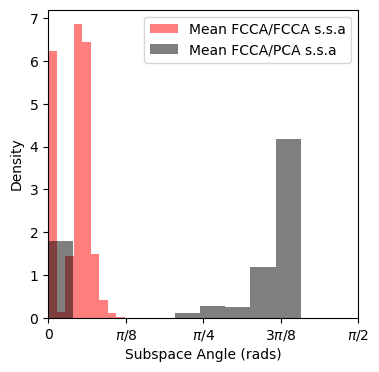

In [49]:
fig, ax = plt.subplots(figsize=(4, 4))

ssa1avg = np.mean(ssa1, axis=-1)
ssa2avg = np.mean(ssa2, axis=-1)

ax.hist(ssa1avg.ravel(), density=True, color='r', alpha=0.5)
ax.hist(ssa2avg.ravel(), density=True, color='k', alpha=0.5)

ax.set_ylabel('Density')
ax.set_xlabel('Subspace Angle (rads)')
ax.set_xlim([0, np.pi/2])
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
ax.legend(['Mean FCCA/FCCA s.s.a', 'Mean FCCA/PCA s.s.a'])
fig.savefig('/home/akumar/nse/neural_control/figs/initvar/sabes_ssa.pdf', bbox_inches='tight', pad_inches=0)

In [5]:
with open('/mnt/Secondary/data/postprocessed/sabes_initvarS1.dat', 'rb') as f:
    sabes_df = pickle.load(f)

In [21]:
sabes_df = pd.DataFrame(sabes_df)

In [6]:
with open('/mnt/Secondary/data/postprocessed/loco_dimreduc_df.dat', 'rb') as f:
    loco_df = pickle.load(f)

In [8]:
loco_df = apply_df_filters(loco_df, region='S1')

In [17]:
loco_df = apply_df_filters(loco_df, dimreduc_method='PCA')

In [22]:
np.unique(sabes_df['data_file'].values)

array(['loco_20170210_03.mat', 'loco_20170213_02.mat',
       'loco_20170214_02.mat', 'loco_20170215_02.mat',
       'loco_20170216_02.mat', 'loco_20170217_02.mat',
       'loco_20170227_04.mat', 'loco_20170228_02.mat',
       'loco_20170301_05.mat', 'loco_20170302_02.mat'], dtype=object)

In [19]:
np.unique(loco_df['data_file'].values)

array(['/mnt/Secondary/data/sabes/loco_20170210_03.mat',
       '/mnt/Secondary/data/sabes/loco_20170213_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170214_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170215_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170216_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170217_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170227_04.mat',
       '/mnt/Secondary/data/sabes/loco_20170228_02.mat',
       '/mnt/Secondary/data/sabes/loco_20170301_05.mat',
       '/mnt/Secondary/data/sabes/loco_20170302_02.mat'], dtype=object)

In [23]:
# Measure angle between reps and angle to PCA subspace
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)
seeds = np.arange(20)

ssa1 = np.zeros((dimvals.size, data_files.size, seeds.size, seeds.size, 5))
ssa2 = np.zeros((dimvals.size, data_files.size, seeds.size, 5))
for i, data_file in enumerate(data_files):
    for j, d in tqdm(enumerate(dimvals)):
        for f in range(5):
            pca_df = apply_df_filters(loco_df, data_file='/mnt/Secondary/data/sabes/%s' % data_file, dim=d, fold_idx=f)

            assert(pca_df.shape[0] == 1)

            for s1 in seeds:
                for s2 in seeds:
                    df1 = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                        dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s1}, fold_idx=f)
                    df2 = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                        dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s2}, fold_idx=f)
                    assert(df1.shape[0] == 1)
                    assert(df2.shape[0] == 1)

                    ssa1[j, i, s1, s2, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['coef'], df2.iloc[0]['coef']))

                    if s1 == s2:
                        ssa2[j, i, s1, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['coef'], pca_df.iloc[0]['coef'][:, 0:d]))

15it [02:25,  9.71s/it]
15it [02:24,  9.63s/it]
15it [02:25,  9.68s/it]
15it [02:31, 10.13s/it]
15it [02:31, 10.12s/it]
15it [02:28,  9.89s/it]
15it [02:30, 10.06s/it]
15it [02:34, 10.27s/it]
15it [02:34, 10.28s/it]
15it [02:35, 10.34s/it]


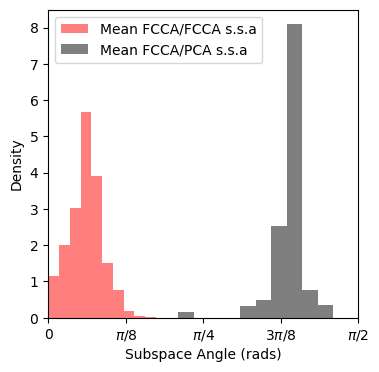

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

ssa1avg = np.mean(ssa1, axis=-1)
ssa2avg = np.mean(ssa2, axis=-1)

ax.hist(ssa1avg.ravel(), density=True, color='r', alpha=0.5)
ax.hist(ssa2avg.ravel(), density=True, color='k', alpha=0.5)

ax.set_ylabel('Density')
ax.set_xlabel('Subspace Angle (rads)')
ax.set_xlim([0, np.pi/2])
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
ax.legend(['Mean FCCA/FCCA s.s.a', 'Mean FCCA/PCA s.s.a'])
fig.savefig('/home/akumar/nse/neural_control/figs/initvar/sabes_ssaS1.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
with open('/mnt/Secondary/data/postprocessed/peanut_decoding_df.dat', 'rb') as f:
    peanut_decoding_df = pickle.load(f)

peanut_decoding_df = pd.DataFrame(peanut_decoding_df)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [63]:
peanut_decoding_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'epoch', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'speed_threshold',
       'dim_vals', 'n_folds', 'data_file', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'loader', 'loader_args', 'dimreduc_file',
       'data_path', 'results_file'],
      dtype='object')

In [65]:
# Measure angle between reps and angle to PCA subspace
dimvals = np.unique(peanut_df['dim'].values)
epochs = np.array([2, 4, 6, 8, 10, 12, 14, 16])
seeds = np.arange(20)

ssa1p = np.zeros((dimvals.size, data_files.size, seeds.size, seeds.size, 5))
ssa2p = np.zeros((dimvals.size, data_files.size, seeds.size, 5))

for i, epoch in enumerate(epochs):
    for j, d in tqdm(enumerate(dimvals)):
        for f in range(5):
            pca_df = apply_df_filters(peanut_decoding_df, epoch=epoch, dim=d, fold_idx=f, dimreduc_method='PCA')
            assert(pca_df.shape[0] == 1)

            for s1 in seeds:
                for s2 in seeds:
                    df1 = apply_df_filters(peanut_df, dimreduc_method='LQGCA', dim=d, 
                                        dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s1}, fold_idx=f,
                                        loader_args={'bin_width': 50,
                                      'epoch': epoch,
                                      'filter_fn': 'none',
                                      'filter_kwargs': {},
                                      'boxcox': 0.5,
                                      'spike_threshold': 200,
                                      'speed_threshold': 4})
                    df2 = apply_df_filters(peanut_df, dimreduc_method='LQGCA', dim=d, 
                                        dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s2}, fold_idx=f,
                                        loader_args={'bin_width': 50,
                                      'epoch': epoch,
                                      'filter_fn': 'none',
                                      'filter_kwargs': {},
                                      'boxcox': 0.5,
                                      'spike_threshold': 200,
                                      'speed_threshold': 4})
                    assert(df1.shape[0] == 1)
                    assert(df2.shape[0] == 1)

                    ssa1p[j, i, s1, s2, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['coef'], df2.iloc[0]['coef']))

                    if s1 == s2:
                        ssa2p[j, i, s1, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['coef'], pca_df.iloc[0]['coef'][:, 0:d]))

15it [04:41, 18.75s/it]
15it [04:08, 16.54s/it]
15it [04:10, 16.71s/it]
15it [04:03, 16.20s/it]
15it [04:02, 16.18s/it]
15it [04:11, 16.74s/it]
15it [04:09, 16.67s/it]
15it [04:11, 16.77s/it]


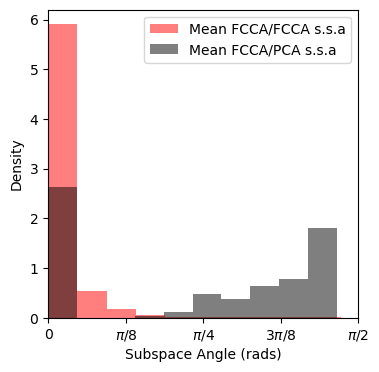

In [48]:
fig, ax = plt.subplots(figsize=(4, 4))

ssa1avg = np.mean(ssa1p, axis=-1)
ssa2avg = np.mean(ssa2p, axis=-1)

ax.hist(ssa1avg.ravel(), density=True, color='r', alpha=0.5)
ax.hist(ssa2avg.ravel(), density=True, color='k', alpha=0.5)

ax.set_ylabel('Density')
ax.set_xlabel('Subspace Angle (rads)')
ax.set_xlim([0, np.pi/2])
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
ax.legend(['Mean FCCA/FCCA s.s.a', 'Mean FCCA/PCA s.s.a'])
fig.savefig('/home/akumar/nse/neural_control/figs/initvar/peanut_ssa.pdf', bbox_inches='tight', pad_inches=0)

In [6]:
# with open('initvar_ssa_tmp.pkl', 'wb') as f:
#     f.write(pickle.dumps(ssa1))
#     f.write(pickle.dumps(ssa2))

#     f.write(pickle.dumps(ssa1p))
#     f.write(pickle.dumps(ssa2p))

with open('initvar_ssa_tmp.pkl', 'rb') as f:
    ssa1 = pickle.load(f)
    ssa2 = pickle.load(f)

    ssa1p = pickle.load(f)
    ssa2p = pickle.load(f)
    # f.write(pickle.dumps(ssa1))
    # f.write(pickle.dumps(ssa2))

    # f.write(pickle.dumps(ssa1p))
    # f.write(pickle.dumps(ssa2p))

### Decoding

In [17]:
# Plot min/max decoding curves for each data file
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)
seeds = np.arange(20)
r2 = np.zeros((dimvals.size, data_files.size, seeds.size, 5))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    for j, d in tqdm(enumerate(dimvals)):
        for s in seeds:
            for f in range(5):
                df = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                    dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s}, fold_idx=f)
                assert(df.shape[0] == 1)
                r2[j, i, s, f] =  df.iloc[0]['r2'][1]

15it [00:03,  4.01it/s]
15it [00:03,  4.22it/s]
15it [00:03,  4.05it/s]
15it [00:03,  4.10it/s]
15it [00:03,  4.02it/s]
15it [00:03,  3.96it/s]
15it [00:03,  3.88it/s]
15it [00:03,  4.22it/s]
15it [00:03,  4.03it/s]
15it [00:03,  3.88it/s]
15it [00:03,  4.20it/s]
15it [00:03,  3.88it/s]
15it [00:03,  4.12it/s]


In [21]:
idxs = np.array([0, 1, 2, 3, 4, 5, 12])

In [22]:
r2avg = np.mean(r2[:, idxs, ...], axis=-1)

In [23]:
r2avg.shape

(15, 7, 20)

In [33]:
dimvals

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [35]:
dimvals.size

15

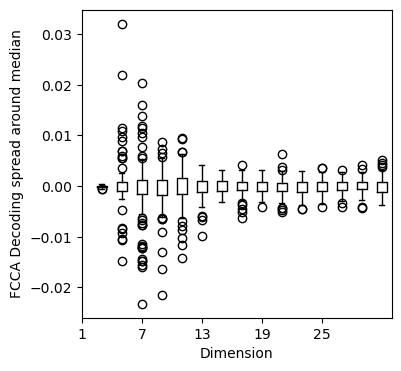

In [43]:
r2avg = np.mean(r2[:, idxs, ...], axis=-1)
r2avgctr = r2avg - np.median(r2avg, axis=-1, keepdims=True)
# Plot the min/max across all reps/data files relative to to the median decoding accuracy across dimensions
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot(r2avgctr.reshape((r2avg.shape[0], -1)).T,  medianprops={'linewidth':0})
ax.set_xticks([0, 3, 6, 9, 12])
ax.set_xticklabels([dimvals[0], dimvals[3], dimvals[6], dimvals[9], dimvals[12]])
ax.set_xlabel('Dimension')
ax.set_ylabel('FCCA Decoding spread around median')
fig.savefig('/home/akumar/nse/neural_control/figs/initvar/sabes_decoding_delta.pdf', bbox_inches='tight', pad_inches=0)
#ax.set_xticks([1, 5, 10, 15, 25])
#ax.set_xticklabels(dimvals)


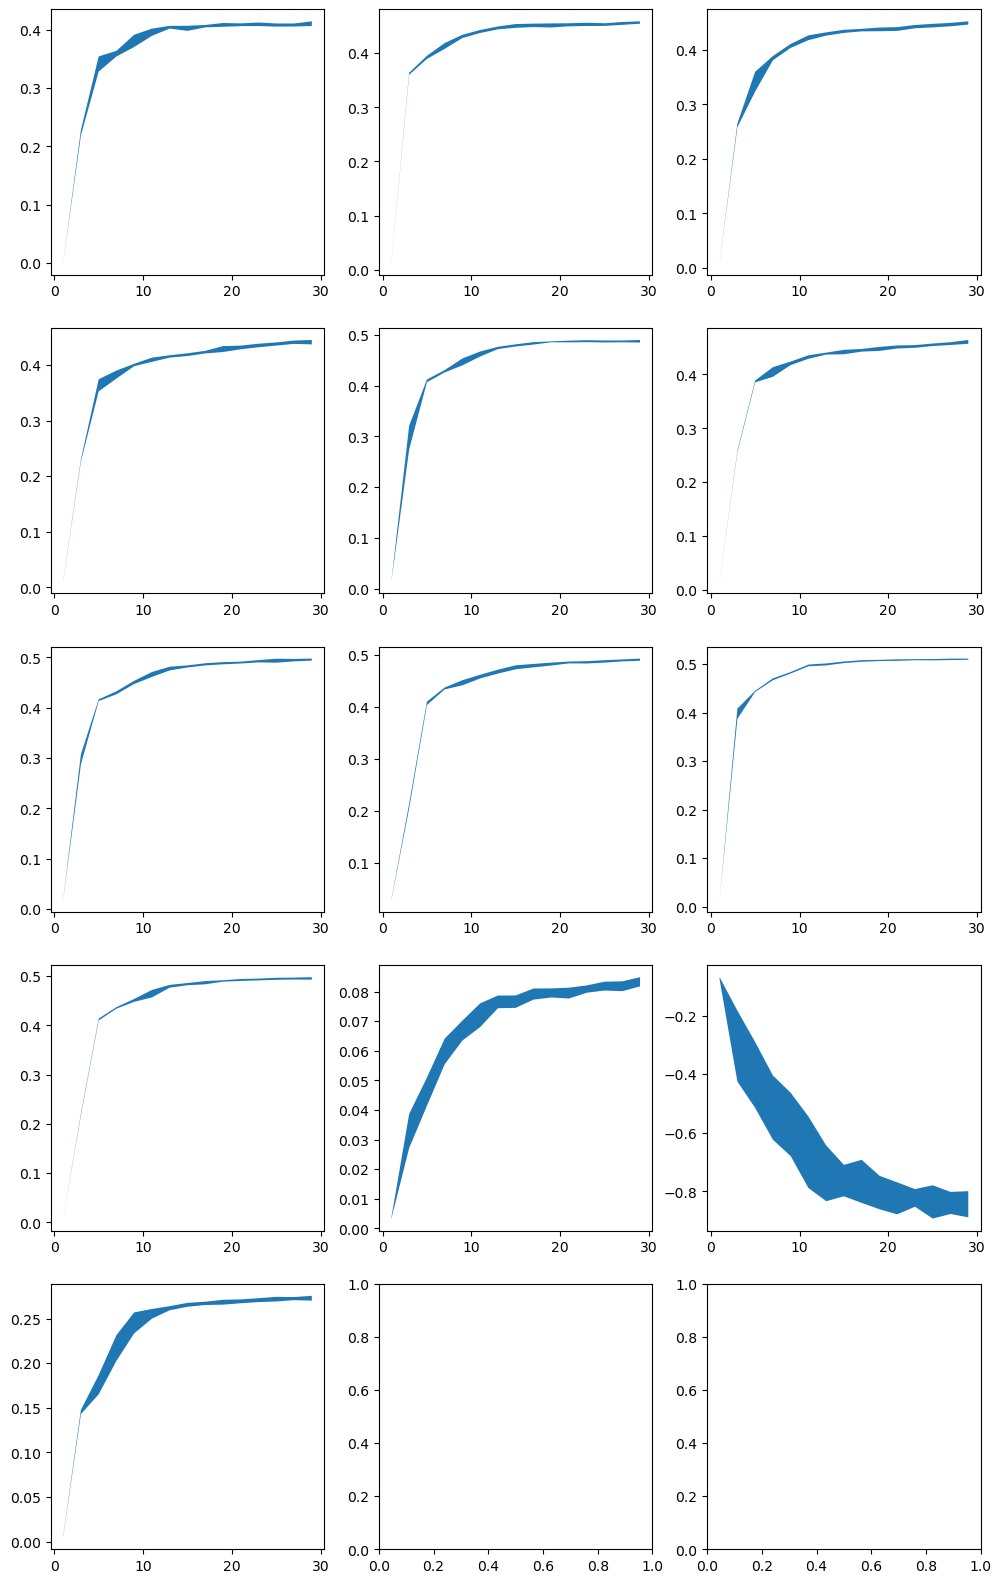

In [77]:
fig, ax = plt.subplots(5, 3, figsize=(12, 20))
r2avg = np.mean(r2, axis=-1)
for i in range(13):
    a = ax[np.unravel_index(i, (5, 3))]
    a.fill_between(dimvals, np.min(r2avg[:, i, :], axis=-1), np.max(r2avg[:, i, :], axis=-1))

In [7]:
# Plot min/max decoding curves for each data file
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)
seeds = np.arange(20)
r2 = np.zeros((dimvals.size, data_files.size, seeds.size, 5))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    for j, d in tqdm(enumerate(dimvals)):
        for s in seeds:
            for f in range(5):
                df = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d, 
                                    dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s}, fold_idx=f)
                assert(df.shape[0] == 1)
                r2[j, i, s, f] =  df.iloc[0]['r2'][1]

15it [00:02,  5.34it/s]
15it [00:02,  5.40it/s]
15it [00:02,  5.52it/s]
15it [00:02,  5.34it/s]
15it [00:02,  5.19it/s]
15it [00:02,  5.25it/s]
15it [00:02,  5.42it/s]


In [8]:
idxs = np.arange(r2.shape[1])

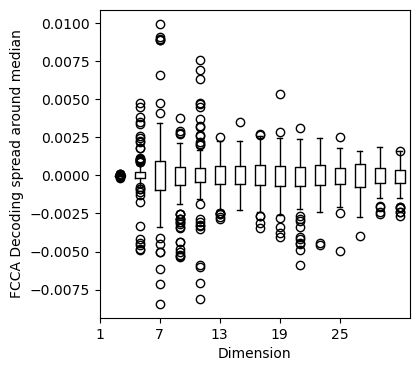

In [10]:
r2avg = np.mean(r2[:, idxs, ...], axis=-1)
r2avgctr = r2avg - np.median(r2avg, axis=-1, keepdims=True)
# Plot the min/max across all reps/data files relative to to the median decoding accuracy across dimensions
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot(r2avgctr.reshape((r2avg.shape[0], -1)).T,  medianprops={'linewidth':0})
ax.set_xticks([0, 3, 6, 9, 12])
ax.set_xticklabels([dimvals[0], dimvals[3], dimvals[6], dimvals[9], dimvals[12]])
ax.set_xlabel('Dimension')
ax.set_ylabel('FCCA Decoding spread around median')
fig.savefig('/home/akumar/nse/neural_control/figs/initvar/sabes_decoding_deltaS1.pdf', bbox_inches='tight', pad_inches=0)
#ax.set_xticks([1, 5, 10, 15, 25])
#ax.set_xticklabels(dimvals)


In [44]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(peanut_df['dim'].values)
epochs = np.array([2, 4, 6, 8, 10, 12, 14, 16])
seeds = np.arange(20)
r2p = np.zeros((dimvals.size, epochs.size, seeds.size, 5))
for i, epoch in enumerate(epochs):
    for j, d in tqdm(enumerate(dimvals)):
        for s in seeds:
            for f in range(5):
                df = apply_df_filters(peanut_df, loader_args={'bin_width': 50,
                                      'epoch': epoch,
                                      'filter_fn': 'none',
                                      'filter_kwargs': {},
                                      'boxcox': 0.5,
                                      'spike_threshold': 200,
                                      'speed_threshold': 4},             
                                       dimreduc_method='LQGCA', dim=d, 
                                       dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':1, 'rng_or_seed':s}, fold_idx=f)
                assert(df.shape[0] == 1)
                r2p[j, i, s, f] = df.iloc[0]['r2'][0]                  

15it [00:07,  1.90it/s]
15it [00:07,  1.95it/s]
15it [00:07,  1.93it/s]
15it [00:07,  1.90it/s]
15it [00:07,  1.93it/s]
15it [00:07,  1.92it/s]
15it [00:07,  1.94it/s]
15it [00:07,  1.95it/s]


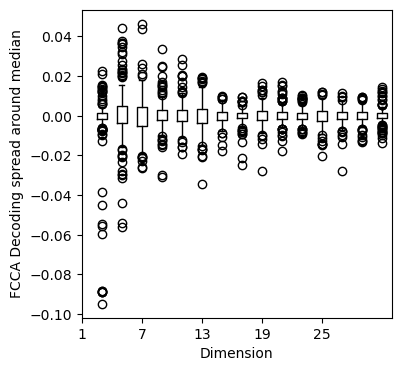

In [47]:
r2avg = np.mean(r2p, axis=-1)
r2avgctr = r2avg - np.median(r2avg, axis=-1, keepdims=True)
# Plot the min/max across all reps/data files relative to to the median decoding accuracy across dimensions
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot(r2avgctr.reshape((r2avg.shape[0], -1)).T,  medianprops={'linewidth':0})
ax.set_xticks([0, 3, 6, 9, 12])
ax.set_xticklabels([dimvals[0], dimvals[3], dimvals[6], dimvals[9], dimvals[12]])
ax.set_xlabel('Dimension')
ax.set_ylabel('FCCA Decoding spread around median')
fig.savefig('/home/akumar/nse/neural_control/figs/initvar/peanut_decoding_delta.pdf', bbox_inches='tight', pad_inches=0)
#ax.set_xticks([1, 5, 10, 15, 25])
#ax.set_xticklabels(dimvals)


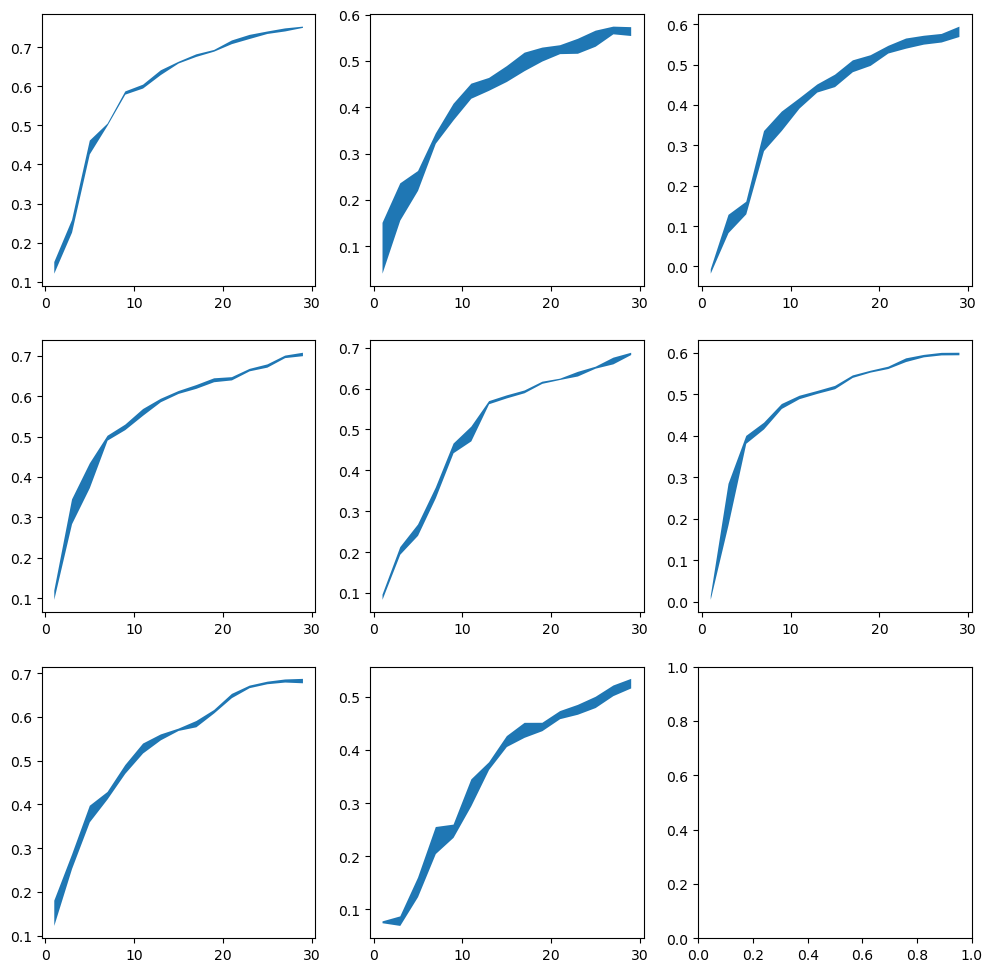

In [79]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
r2avg = np.mean(r2p, axis=-1)
for i in range(8):
    a = ax[np.unravel_index(i, (3, 3))]
    a.fill_between(dimvals, np.min(r2avg[:, i, :], axis=-1), np.max(r2avg[:, i, :], axis=-1))

### CV initvar from NERSC

In [5]:
import glob

In [63]:
# Consoldiate
fls = glob.glob('/mnt/Secondary/data/cvT402/*.pkl')
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        task = pickle.load(f)
        accuracy = pickle.load(f)
        lqg_coef = pickle.load(f)
        pca_coef = pickle.load(f)
        fca_scores = pickle.load(f)

    # Get the lqg seed from the filename
    lqg_seed = int(fl.split('seed_')[1].split('.pkl')[0])

    # Unpack task
    d, fold_idx = task
    result = {}
    result['dim'] = d
    result['fold_idx'] = fold_idx
    result['accuracy'] = accuracy
    result['lqg_coef'] = lqg_coef
    result['pca_coef'] = pca_coef
    result['fca_scores'] = fca_scores
    result['seed'] = lqg_seed 

    rl.append(result)

In [64]:
cvdf = pd.DataFrame(rl)

In [65]:
dimvals = np.unique(cvdf['dim'].values)
folds = np.unique(cvdf['fold_idx'].values)
seeds = np.unique(cvdf['seed'].values)

In [75]:
# Assemble accuracy matrix
accuracy = np.zeros((dimvals.size, folds.size, seeds.size, 4))

for i, d in tqdm(enumerate(dimvals)):
    for f in folds:
        for k in seeds:
            df_ = apply_df_filters(cvdf, dim=d, fold_idx=f, seed=k)
            assert(df_.shape[0] == 1)
            accuracy[i, f, k, :] = df_.iloc[0]['accuracy'].squeeze()

13it [00:00, 20.42it/s]


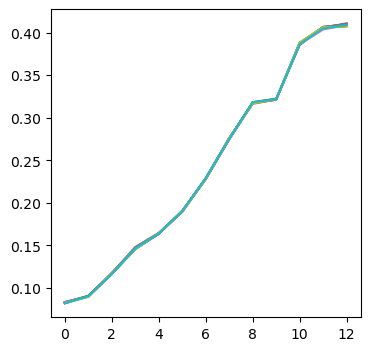

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
for k in range(10):
    ax.plot(np.mean(accuracy[..., k, 3], axis=1))
#ax.plot(np.mean(accuracy[..., 2, 1], axis=1))

In [44]:
with open('pca_cv_decoding_tmp.pkl', 'rb') as f:
    accuracy_pca = pickle.load(f)

In [45]:
accuracy.shape

(13, 10, 10, 4)

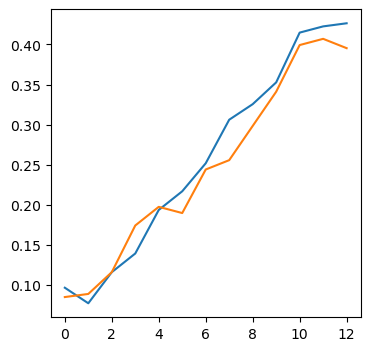

In [57]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(accuracy[:, 0, 9, 3])
ax.plot(accuracy_pca[0, :, 1])

In [33]:
dimvals.size

13

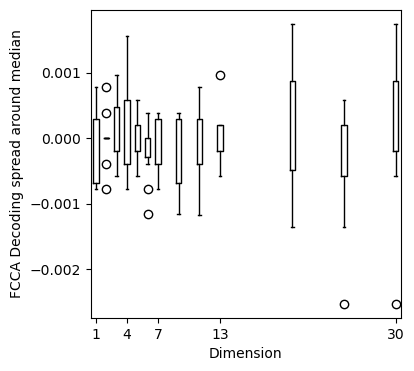

In [38]:
# Median dispersion
r2avg = np.mean(accuracy[..., 3], axis=1)
r2avgctr = r2avg - np.median(r2avg, axis=1, keepdims=True)
# Plot the min/max across all reps/data files relative to to the median decoding accuracy across dimensions
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot(r2avgctr.reshape((r2avg.shape[0], -1)).T,  positions=dimvals, medianprops={'linewidth':0})
#ax.set_xticks(dimvals)
ax.set_xticks([dimvals[0], dimvals[3], dimvals[6], dimvals[9], dimvals[12]])
ax.set_xticklabels([dimvals[0], dimvals[3], dimvals[6], dimvals[9], dimvals[12]])
ax.set_xlabel('Dimension')
ax.set_ylabel('FCCA Decoding spread around median')
fig.savefig('/home/akumar/nse/neural_control/figs/initvar/cv_decoding_delta.pdf', bbox_inches='tight', pad_inches=0)

In [42]:
# Subspace angles
ssa1 = np.zeros((dimvals.size, seeds.size, seeds.size, 5))
ssa2 = np.zeros((dimvals.size, seeds.size, 5))

for i, d in tqdm(enumerate(dimvals)):
    for f in folds:
        for s1 in seeds:
            for s2 in seeds:
                df1 = apply_df_filters(cvdf, fold_idx=f, dim=d, seed=s1)
                df2 = apply_df_filters(cvdf, fold_idx=f, dim=d, seed=s2)

                assert(df1.shape[0] == 1)
                assert(df2.shape[0] == 1)

                ssa1[i, s1, s2, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['lqg_coef'], df2.iloc[0]['lqg_coef']))

                if s1 == s2:
                    ssa2[i, s1, f] = np.mean(scipy.linalg.subspace_angles(df1.iloc[0]['lqg_coef'], df1.iloc[0]['pca_coef'][:, 0:d]))

0it [00:00, ?it/s]


ValueError: A and B must have the same number of rows, got 86 and 22188

In [43]:
df1.iloc[0]['pca_coef'].shape

(22188, 1)

In [67]:
# Proper application of PCA:

fls = glob.glob('/mnt/Secondary/data/cvT403/*.pkl')
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        task = pickle.load(f)
        accuracy = pickle.load(f)

    # Get the lqg seed from the filename
    lqg_seed = int(fl.split('seed_')[1].split('.pkl')[0])

    # Unpack task
    d, fold_idx = task
    result = {}
    result['dim'] = d
    result['fold_idx'] = fold_idx
    result['accuracy'] = accuracy
    # result['lqg_coef'] = lqg_coef
    # result['pca_coef'] = pca_coef
    # result['fca_scores'] = fca_scores
    # result['seed'] = lqg_seed 

    rl.append(result)

In [68]:
cvdf2 = pd.DataFrame(rl)

In [70]:
# Assemble accuracy matrix
accuracy_pca = np.zeros((dimvals.size, folds.size, 4))

for i, d in tqdm(enumerate(dimvals)):
    for f in folds:
        df_ = apply_df_filters(cvdf2, dim=d, fold_idx=f)
        assert(df_.shape[0] == 1)
        accuracy_pca[i, f, :] = df_.iloc[0]['accuracy'].squeeze()

13it [00:00, 282.78it/s]


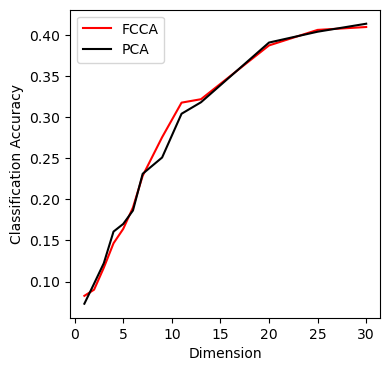

In [80]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(dimvals, np.mean(np.mean(accuracy[..., 3], axis=1), axis=1), color='r')
ax.plot(dimvals, np.mean(accuracy_pca[:, :, 1], axis=1), color='k')

ax.set_ylabel('Classification Accuracy')
ax.set_xlabel('Dimension')
ax.legend(['FCCA', 'PCA'])
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cv_decoding_corrected.pdf', bbox_inches='tight', pad_inches=0)

In [1]:
# Iterate over all data files and return the number of single units in each of M1 and S1
import numpy as np
import glob
import sys

In [2]:
sys.path.append('/home/akumar/nse/neural_control')

In [3]:
from loaders import load_sabes

In [4]:
data_files = glob.glob('/mnt/Secondary/data/sabes/*.mat')

In [5]:
M1_units = []
S1_units = []
for data_file in data_files:
    dat = load_sabes(data_file, region='M1')
    M1_units.append(dat['spike_rates'].shape[-1])
    dat = load_sabes(data_file, region='S1')
    S1_units.append(dat['spike_rates'].shape[-1])

0
96
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
96
96
96
96
96
96
96
96
96
96


In [8]:
np.min(M1_units)

97

In [9]:
np.max(M1_units)

200

In [10]:
s1nz = np.array(S1_units)[np.array(S1_units) > 0]

In [12]:
np.min(s1nz)

86

In [13]:
np.max(s1nz)

187